In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_5

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
electrons_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(electrons_df, config=FIVE_LAYERS)
del electrons_df
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
photons_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(photons_df, config=FIVE_LAYERS)
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
pi0_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(pi0_df, config=FIVE_LAYERS)
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
pi_charged_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(pi_charged_df, config=FIVE_LAYERS)
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330803


## 1.5 Combine Different Particles

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

In [12]:
# combine the datasets
experiment = electrons + photons + pi0 + pi_char

# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

1592154


# 2. Train Model With No Changes

Hyperparam scan najpierw, \
potem zachowanie modelu tzn wszystkie te ploty erorow itd \
potem plyw noise thresholds \
potem wplyw z cutu \

## Jesli ten hyperparam scan wykaze ze inne wartosci lepsze -> uzyj tych innych, ale tu nie mam na mysli depth i num_rounds

In [13]:
# split data into training and testing, next train XGBoost model
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
print(experiment.X_test.shape)

(318431, 22)


In [14]:
max_depth_range = [6, 7]
learning_rate_range = [0.18, 0.19]
subsample_range = [0.8, 0.9, 1.0]
colsample_bytree_range = [0.8, 0.9, 1.0]
num_rounds_grid = [500, 600, 700]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range,
        learning_rate_range,
        subsample_range,
        colsample_bytree_range,
        num_rounds_grid,
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, subsample, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 3804.4330952104483
INFO: Trained XGBoost model; mean squared error: 3777.666724861206
INFO: Trained XGBoost model; mean squared error: 3754.8181082131396
INFO: Trained XGBoost model; mean squared error: 3793.580961828259
INFO: Trained XGBoost model; mean squared error: 3765.6594192555094
INFO: Trained XGBoost model; mean squared error: 3744.6230309494877
INFO: Trained XGBoost model; mean squared error: 3792.673398758905
INFO: Trained XGBoost model; mean squared error: 3761.00502839521
INFO: Trained XGBoost model; mean squared error: 3743.1971315097794
INFO: Trained XGBoost model; mean squared error: 3789.916473250155
INFO: Trained XGBoost model; mean squared error: 3760.13849825997
INFO: Trained XGBoost model; mean squared error: 3737.424108329629
INFO: Trained XGBoost model; mean squared error: 3776.5464072164777
INFO: Trained XGBoost model; mean squared error: 3749.8752322486366
INFO: Trained XGBoost model; mean squared error: 3729.304

In [15]:
mask = experiment_hyperparams.sort_values(by="MSE")["Nodes NO"] < 40000

experiment_hyperparams.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,subsample,colsample_bytree,n_estimators,Nodes NO
104,3663.526050,reg:squarederror,7,0.19,1.0,0.9,700,80345
74,3667.225519,reg:squarederror,7,0.18,1.0,0.8,700,80704
77,3667.395840,reg:squarederror,7,0.18,1.0,0.9,700,80014
101,3668.869417,reg:squarederror,7,0.19,1.0,0.8,700,80851
103,3672.825328,reg:squarederror,7,0.19,1.0,0.9,600,69294
...,...,...,...,...,...,...,...,...
9,3789.916473,reg:squarederror,6,0.18,0.9,0.8,500,30255
6,3792.673399,reg:squarederror,6,0.18,0.8,1.0,500,30190
3,3793.580962,reg:squarederror,6,0.18,0.8,0.9,500,30279
33,3794.896324,reg:squarederror,6,0.19,0.8,1.0,500,30136


In [16]:
# hyperparameters used
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}

experiment.train_xgboost_model(params)

INFO: Trained XGBoost model; mean squared error: 3738.2218767895943


3738.2218767895943

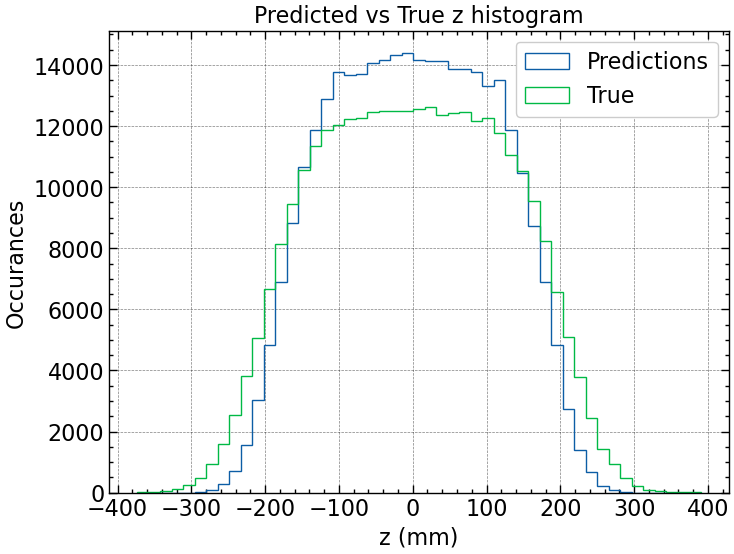

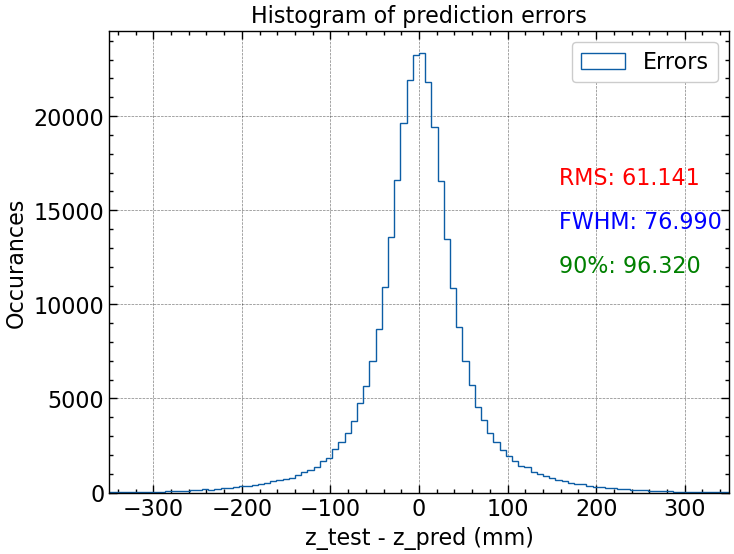

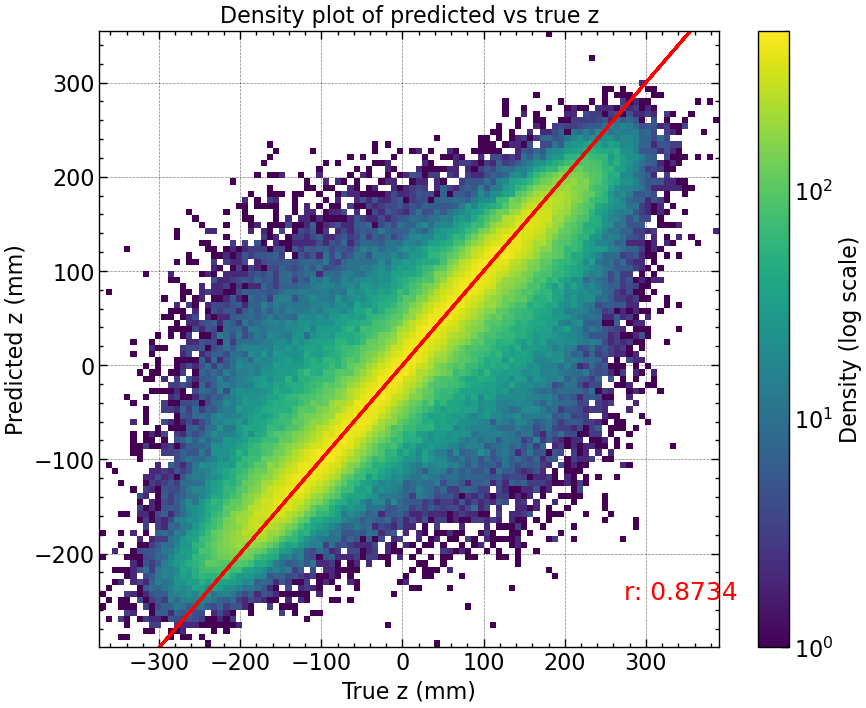

In [17]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

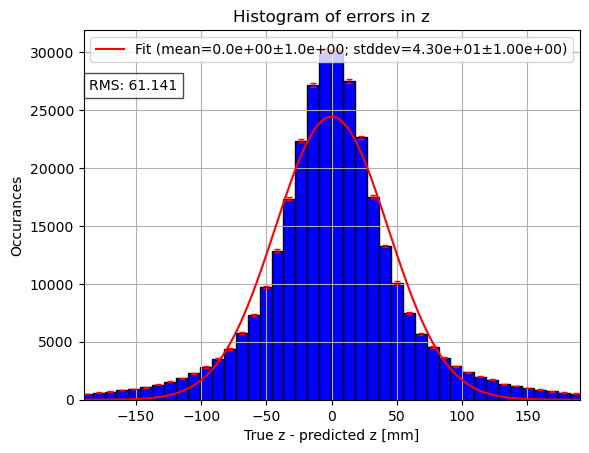

(array([2.44177722e+04, 1.38324444e-02, 4.32817818e+01]),
 array([1104.35549598,    1.48198985,    1.27892818]))

In [18]:
utils.fit_gaussian_to_data(
    data=Y_test - Y_pred,
    initial_guesses=[8000, 0, 36],
    binnum=100,
    plot=True,
    maxfev=None,
    x_label="True z - predicted z [mm]",
    y_label=None,
    title="Histogram of errors in z",
    combine_bins=True,
    binnum_correction=False,
    xlim=(-190, 190),
)

# 3. Noise Thresholds Investigation

In [19]:
# hyperparameters used
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}

In [20]:
layers = FIVE_LAYERS.layers

# Define the threshold range
threshold_range = range(0, 161, 20)

# Generate dictionaries with increasing threshold values for all layers
threshold_permutations = []
for threshold in threshold_range:
    threshold_dict = {layer: threshold for layer in layers}
    threshold_permutations.append(threshold_dict)

threshold_permutations

[{'psb': 0, 'emb1': 0, 'emb2': 0, 'emb3': 0, 'hab1': 0},
 {'psb': 20, 'emb1': 20, 'emb2': 20, 'emb3': 20, 'hab1': 20},
 {'psb': 40, 'emb1': 40, 'emb2': 40, 'emb3': 40, 'hab1': 40},
 {'psb': 60, 'emb1': 60, 'emb2': 60, 'emb3': 60, 'hab1': 60},
 {'psb': 80, 'emb1': 80, 'emb2': 80, 'emb3': 80, 'hab1': 80},
 {'psb': 100, 'emb1': 100, 'emb2': 100, 'emb3': 100, 'hab1': 100},
 {'psb': 120, 'emb1': 120, 'emb2': 120, 'emb3': 120, 'hab1': 120},
 {'psb': 140, 'emb1': 140, 'emb2': 140, 'emb3': 140, 'hab1': 140},
 {'psb': 160, 'emb1': 160, 'emb2': 160, 'emb3': 160, 'hab1': 160}]

In [21]:
threshold_permutations = threshold_permutations + [
    {"psb": 100, "emb1": 50, "emb2": 100, "emb3": 50, "hab1": 100},
    {"psb": 50, "emb1": 50, "emb2": 50, "emb3": 50, "hab1": 100},
    {"psb": 80, "emb1": 50, "emb2": 80, "emb3": 50, "hab1": 100},
    {"psb": 70, "emb1": 50, "emb2": 70, "emb3": 70, "hab1": 100},
    {"psb": 46, "emb1": 10, "emb2": 30, "emb3": 21, "hab1": 17},
]

MSE_results = []

# loop over noise thresholds permutations
for directory in threshold_permutations:
    # importing data
    electrons_df = pd.read_parquet(
        r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
    )
    electrons = Experiment(electrons_df, config=FIVE_LAYERS)
    photons_df = pd.read_parquet(
        r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
    )
    photons = Experiment(photons_df, config=FIVE_LAYERS)
    pi0_df = pd.read_parquet(
        r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
    )
    pi0 = Experiment(pi0_df, config=FIVE_LAYERS)
    pi_charged_df = pd.read_parquet(
        r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
    )
    pi_char = Experiment(pi_charged_df, config=FIVE_LAYERS)

    # set noises to new value, then proceed to denoisify and
    # train model with those new values
    electrons.set_noise_thresholds(directory)
    photons.set_noise_thresholds(directory)
    pi0.set_noise_thresholds(directory)
    pi_char.set_noise_thresholds(directory)

    electrons.remove_duplicates()
    electrons.denoisify()
    electrons.shuffle_dataset(repeats=1)
    mask = electrons.tot_layers_et() > 0
    electrons.remove_events(mask=mask)

    photons.remove_duplicates()
    photons.denoisify()
    photons.shuffle_dataset(repeats=1)
    mask = photons.tot_layers_et() > 0
    photons.remove_events(mask=mask)

    pi0.remove_duplicates()
    pi0.denoisify()
    pi0.shuffle_dataset(repeats=1)
    mask = pi0.tot_layers_et() > 0
    pi0.remove_events(mask=mask)

    pi_char.remove_duplicates()
    pi_char.denoisify()
    pi_char.shuffle_dataset(repeats=1)
    mask = pi_char.tot_layers_et() > 0
    pi_char.remove_events(mask=mask)

    # combine and shuffle
    experiment = electrons + photons + pi0 + pi_char
    del electrons
    del photons
    del pi0
    del pi_char
    experiment.shuffle_dataset(repeats=11)

    experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
    current_mse = experiment.train_xgboost_model(params)

    MSE_results.append({**directory, "Mean Squared Error": current_mse})
    del experiment


df = pd.DataFrame(MSE_results)

df  # 3640.2703203573874

INFO: Trained XGBoost model; mean squared error: 3640.2703203573874
INFO: Trained XGBoost model; mean squared error: 3646.260860731691


MemoryError: Unable to allocate 3.80 GiB for an array with shape (320, 1592159) and data type float64

In [ ]:
df

,psb,emb1,emb2,emb3,hab1,Mean Squared Error
0,0,0,0,0,0,3640.270320
1,20,20,20,20,20,3646.260861
2,40,40,40,40,40,3696.036007
3,60,60,60,60,60,3714.648295
4,80,80,80,80,80,3714.587234
5,100,100,100,100,100,3744.618811
6,120,120,120,120,120,3788.693036
7,140,140,140,140,140,3829.029310
8,160,160,160,160,160,3847.734494
9,100,50,100,50,100,3742.001769
